# Advanced Lane Finding Project:
------------------------------------------------------

    The Project finds lane lines. The below code has a pipeline which is first applied on test images and then on a vedio. The left lane is highlighted in RED, right lane in BLUE and the entire lane region is highlighted in GREEN.
    The pipeline here has below steps:
    1. Calibrate Camera
    2. Undistort the input image
    3. Warp the undistorted image
    4. Transform warped image to grayscale
    5. Apply Gradient threshold on the gray image and obtain a binary image
    6. Apply HLS transform and get binary image by applying color thresholds
    7. Combine the above two binaries
    8. Find left and right lanes on the image and highlight them
    9. Unwarp the image obtained in step 8
    10. Place the highlighted area of the image from step 9 onto the original image.


    Import the libraries "matplotlib", "numpy", "OpenCV" to perform the above pipeline of operations.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import collections
%matplotlib inline

    Below are the helper functions used in the pipeline mentioned above. The usage of each function is mentioned in the comments.

In [2]:
def convert_to_gray(image_imput):
    """Function converts a BGR image to Gray Scale."""
    return cv2.cvtColor(image_imput,cv2.COLOR_BGR2GRAY)

def find_corners(gray_img, board_size):
    """Function finds corners on a chessboard image"""
    return cv2.findChessboardCorners(gray_img, board_size, None)

def add_obj_and_image_point(objpoints, imgpoints, ret, corners):
    """Function add the corners of chess board to OBJECT and IMAGE points"""
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    return objpoints, imgpoints

def calibrate_camera(objpoints, imgpoints, gray_img):
    """Functions takes OBJECT and IMAGE points and caliberates camera. """
    return cv2.calibrateCamera(objpoints, imgpoints, gray_img.shape[::-1], None, None)

def undistorted_image(image_input, mtx, dist):
    """Function undistorts input image using the Caliberation and Distortion Matrix of Camera"""
    return cv2.undistort(image_input, mtx, dist, None, mtx)

def get_src_dst_for_warp(input_image):
    """Generates source and destination points for warpping the input image"""
    x_len = input_image.shape[1]
    y_len = input_image.shape[0]
    src = np.float32([
        [x_len/2 + 80, 450], [x_len/2 + 500, y_len], [x_len/2 - 500, y_len], [x_len/2 - 80, 450]
    ])
    dst = np.float32([
        [x_len/2 + 500, 0], [x_len/2 + 500, y_len], [x_len/2 - 500, y_len], [x_len/2 - 500, 0]
    ])
    
    return src, dst

def get_perspective_transform_params(src, dst):
    """Function Generates parameters to apply perspective transform on a given image."""
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def get_perspective_transformed_image(input_img, M, img_size):
    """Functions generates warpped image for the input image"""
    warped = cv2.warpPerspective(input_img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def get_scaled_sobel(gray_input, orient='x', kernel_input='3'):
    """Generates scaled sobel images for x or y or both x and y directions"""
    abs_sobel = None
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_input, cv2.CV_64F, 1, 0, kernel_input))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray_input, cv2.CV_64F, 0, 1, kernel_input))
    if orient == 'xy':
        abs_sobel = np.absolute(cv2.Sobel(gray_input, cv2.CV_64F, 1, 0, kernel_input)**2 + cv2.Sobel(gray_input, cv2.CV_64F, 0, 1, kernel_input)**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel

def apply_mag_threshold(scaled_sobel, mag_thresh):
    """Applies magnitude thresholds for the scaled sobel images"""
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def get_hls_threshold_binary(input_image, thresh, channel='s'):
    """Function applies HLS transform for BGR image and provides binary image as per the provided thresholds."""
    hls = cv2.cvtColor(input_image, cv2.COLOR_BGR2HLS)
    channel_img = None
    if channel == 'h':
        channel_img = hls[:,:,0]
    elif channel == 'l':
        channel_img = hls[:,:,1]
    else:
        channel_img = hls[:,:,2]
    binary_output = np.zeros_like(channel_img)
    binary_output[(channel_img > thresh[0]) & (channel_img <= thresh[1])] = 1
    return binary_output

def combine_binary(binary_1, binary_2):
    """Function combines two binary images"""
    combined_bin_img = np.zeros_like(binary_1)
    combined_bin_img[(binary_1 == 1) | (binary_2 == 1)] = 1
    return combined_bin_img

def get_hist_out_img_and_base_points(binary_warped):
    """Functions generates hostogram for bottom half of the binary image"""
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return histogram, out_img, midpoint, leftx_base, rightx_base

def get_height_and_nonzeros(binary_warped, nwindows):
    """Function provides the height of window required for searching lane lines and provides the non zero values from 
       binary image"""
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return window_height, nonzero, nonzeroy, nonzerox

def get_left_and_right_lane_indices(binary_warped, leftx_base, rightx_base, 
                                    nwindows, window_height, margin, minpix, 
                                    nonzeroy, nonzerox, GLOBAL_DEQUEUE_COEFFS, out_img):
    """Function calculates left and right lane indices from the given binary image"""
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    # If applied on a single image or first image of a vedio, entire window technique is applied
    if GLOBAL_DEQUEUE_COEFFS == None or len(GLOBAL_DEQUEUE_COEFFS) == 0:
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
        
            # Draw the windows on the visualization image
            # cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            # cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) 
                              & (nonzeroy < win_y_high) 
                              & (nonzerox >= win_xleft_low) 
                              &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) 
                               & (nonzeroy < win_y_high) 
                               & (nonzerox >= win_xright_low) 
                               &  (nonzerox < win_xright_high)).nonzero()[0]
        
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
        
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        return leftx_current, rightx_current, left_lane_inds, right_lane_inds
    # If the lanes are found on previous frames only region of interest is taken.
    elif len(GLOBAL_DEQUEUE_COEFFS) > 0:
        left_fit, right_fit = get_average_from_global(GLOBAL_DEQUEUE_COEFFS)
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                           left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                           left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                            right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        return leftx_current, rightx_current, left_lane_inds, right_lane_inds
            
def extract_left_and_right_lane_pixel_positions(left_lane_inds, right_lane_inds, nonzerox, nonzeroy):
    """Function extracts left and right lane pixel positions. """
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty
    

def get_lane_pixels(binary_warped, num_windows, margin, minpix, GLOBAL_DEQUEUE_COEFFS, use_prior):
    """Function calculates left and right lane postions and generates an output image highlighting the lanes"""
    histogram, out_img, midpoint, leftx_base, rightx_base = get_hist_out_img_and_base_points(binary_warped)

    nwindows = num_windows
    margin = margin
    minpix = minpix

    window_height, nonzero, nonzeroy, nonzerox = get_height_and_nonzeros(binary_warped, num_windows)
    
    # Current positions to be updated later for each window in nwindows
    leftx_current, rightx_current, left_lane_inds, right_lane_inds =  get_left_and_right_lane_indices(binary_warped, 
                                                                                                      leftx_base, 
                                                                                                      rightx_base, 
                                                                                                      nwindows, 
                                                                                                      window_height, 
                                                                                                      margin, 
                                                                                                      minpix, 
                                                                                                      nonzeroy, 
                                                                                                      nonzerox, 
                                                                                                      GLOBAL_DEQUEUE_COEFFS,
                                                                                                      out_img)
    leftx, lefty, rightx, righty = extract_left_and_right_lane_pixel_positions(left_lane_inds, 
                                                                                        right_lane_inds, 
                                                                                        nonzerox, nonzeroy)
    return leftx, lefty, rightx, righty, out_img

def get_poly_fits(leftx, lefty, rightx, righty):
    """Function generates second order polynomial coefficients for left and right lanes. """
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def get_average_from_global(GLOBAL_DEQUEUE_COEFFS):
    """Functions calculates the average of last 10 coefficients for left and right lanes."""
    new_left_fit = [[], [], []]
    new_right_fit = [[], [], []]
    for val in GLOBAL_DEQUEUE_COEFFS:
        new_left_fit[0].append(val[0][0])
        new_left_fit[1].append(val[0][1])
        new_left_fit[2].append(val[0][2])
        new_right_fit[0].append(val[1][0])
        new_right_fit[1].append(val[1][1])
        new_right_fit[2].append(val[1][2])
    left_fit = [sum(new_left_fit[0])/len(new_left_fit[0]), 
                sum(new_left_fit[1])/len(new_left_fit[1]), 
                sum(new_left_fit[2])/len(new_left_fit[2])]
    right_fit = [sum(new_right_fit[0])/len(new_right_fit[0]), 
                 sum(new_right_fit[1])/len(new_right_fit[1]), 
                 sum(new_right_fit[2])/len(new_right_fit[2])]
    return left_fit, right_fit
    
def get_params_using_prior(GLOBAL_DEQUEUE_COEFFS, left_fit, right_fit):
    """Function adds current polynomial coefficients to a DEQUEUE and gets the average coefficients."""
    GLOBAL_DEQUEUE_COEFFS.append((left_fit, right_fit))
    left_fit, right_fit = get_average_from_global(GLOBAL_DEQUEUE_COEFFS)
    return left_fit, right_fit
    
def gen_x_y_values_for_plotting(binary_warped, left_fit, right_fit):
    """Generates x and y points to highlight on output image."""
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return ploty, left_fitx, right_fitx

def get_meter_pre_pix():
    """Provides pixel to meters conversion values"""
    ym_per_pix = 3.0/100
    xm_per_pix = 3.7/900
    return ym_per_pix, xm_per_pix

def get_curvatures(left_fit, right_fit, y_eval, ym_per_pix):
    """Calculates the curvature of the left and right lanes"""
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def fill_color_between_lanes(left_fitx, right_fitx, ploty, out_img):
    """Fills light green color between the lanes"""
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(out_img, np.int_([pts]), (152,251,152))
    
    return out_img
    
def fit_polynomial(binary_warped, num_windows, margin, minpix, GLOBAL_DEQUEUE_COEFFS=None, use_prior=False):
    """Function fits a polynomial for the points generated for left and right lanes. Also highlights the lanes. """
    ym_per_pix, xm_per_pix = get_meter_pre_pix()
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = get_lane_pixels(binary_warped, num_windows, margin, minpix, 
                                                           GLOBAL_DEQUEUE_COEFFS, use_prior)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit, right_fit = get_poly_fits(leftx, lefty, rightx, righty)
    if use_prior:
        left_fit, right_fit = get_params_using_prior(GLOBAL_DEQUEUE_COEFFS, left_fit, right_fit)

    # Generate x and y values for plotting
    ploty, left_fitx, right_fitx = gen_x_y_values_for_plotting(binary_warped, left_fit, right_fit)
   
    y_eval = np.max(ploty)
    
    ym_per_pix, xm_per_pix = get_meter_pre_pix()
        
    # Calculates left and right lane curvature and the offset of lane center from the image center
    left_curverad, right_curverad = get_curvatures(left_fit, right_fit, y_eval, ym_per_pix)
    offset_in_img = ( binary_warped.shape[1]/2 - ((leftx[-1] + rightx[-1])/2) ) * xm_per_pix

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    out_img = fill_color_between_lanes(left_fitx, right_fitx, ploty, out_img)
    
    return out_img, left_curverad, right_curverad, offset_in_img, left_fitx, right_fitx, ploty

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """Function puts the highlighted lanes on the actual image."""
    return cv2.addWeighted(initial_img, α, img, β, γ)
    
def plot_image(image_input):
    plt.imshow(image_input)

    The below functions caliberates the camera and provides the Calibration and Distortion matrices.

In [3]:
def caliberate_camera():
    """Function Caliberates the Camera and Provides Calibration Matrix and the Distortion Coefficients"""
    calibration_images = os.listdir("camera_cal/")
    objpoints = []
    imgpoints = []
    sample_gray_image = None
    for cal_image in calibration_images:
        image = mpimg.imread('camera_cal/{}'.format(cal_image))
        gray_image = convert_to_gray(image)
        sample_gray_image = gray_image
        ret, corners = find_corners(gray_image, (9, 6))
        objpoints, imgpoints = add_obj_and_image_point(objpoints, imgpoints, ret, corners)
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(objpoints, imgpoints, sample_gray_image)
    return mtx, dist

In [4]:
def get_test_image(num):
    """Function loads the test images."""
    test_images = os.listdir("test_images/")
    num_imgs = len(test_images)
    if num <= num_imgs - 1:
        return mpimg.imread('test_images/{}'.format(test_images[num]))
    else:
        return mpimg.imread('test_images/{}'.format(test_images[0]))

    Below is the pipeline that highlights the lanes on road and calculates radius of curvature and Offset of lane center.

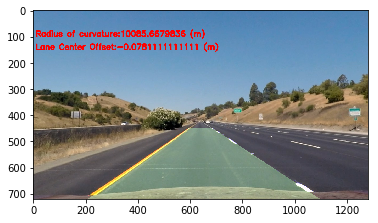

In [5]:
# Below global variable holds the coefficiets of the lanes lines previously found
GLOBAL_DEQUEUE_COEFFS = collections.deque(maxlen=10)


def process_pipeline(img_num):
    """Functions performs the pipeline of processes on the input image. """
    # Caliberate Camera and obtain Calibration Matrix and Distortioon Coefficients
    mtx, dist = caliberate_camera()
    
    # Undistorted the input image
    actual_image = get_test_image(img_num)
    actual_image_undistorted = undistorted_image(actual_image, mtx, dist)
    
    # Apply Perspective Transform on Undistorted Image
    src, dst = get_src_dst_for_warp(actual_image_undistorted)
    M, Minv = get_perspective_transform_params(src, dst)
    warped_img = get_perspective_transformed_image(actual_image_undistorted, M, (1280, 720))
    
    # Convert Image to Gray Scale
    gray_image = convert_to_gray(warped_img)
    
    # Obtain Sobel Binary for the grayscale image
    scaled_sobel = get_scaled_sobel(gray_image, orient='x', kernel_input=31)
    sobel_binary = apply_mag_threshold(scaled_sobel, (20, 100))
    
    # Obtain Color Threshold bunary of HLS tranformed Image.
    hls_s_binary = get_hls_threshold_binary(warped_img, (170, 255), 's')
    
    # Combine Gradient Threshold and Color Threshold binaries.
    combined_bin_img = combine_binary(sobel_binary, hls_s_binary)
    
    # Obtain left and right lane pixel values and fit polynomial
    out_img, left_curverad, right_curverad, offset_in_img, left_fitx, right_fitx, ploty = fit_polynomial(combined_bin_img, 
                                                                                                         9, 100, 50)
    
    
    # Unwarp the image
    out_img_wrapped = get_perspective_transformed_image(out_img, Minv, (1280, 720))
    
    # Hightlight lanes on actual image
    output = weighted_img(out_img_wrapped, actual_image_undistorted, 1, 0.3, 1)
    
    # Write curvature and offset onto image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text1 = 'Radius of curvature:' + str((left_curverad+right_curverad)/2) + ' (m)'
    text2 = 'Lane Center Offset:' + str(offset_in_img) + ' (m)'
    cv2.putText(output, text1, (10,100), font, 1, (255, 0, 0), 4, cv2.LINE_AA)
    cv2.putText(output, text2, (10,150), font, 1, (255, 0, 0), 4, cv2.LINE_AA)
    
    return output

plot_image(process_pipeline(0))

for i in range(8):
    output = process_pipeline(i)
    mpimg.imsave('output_images/output_{}.jpg'.format(i), output)
    

    Import libraries to run Pipeline on vedio.

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
# Caliberate Camera and obtain Calibration Matrix and Distortioon Coefficients
MTX, DIST = caliberate_camera()

# Below global variable holds the coefficiets of the lanes lines found on last 10 frames.
GLOBAL_DEQUEUE_COEFFS = collections.deque(maxlen=10)

def process_image(image):
    """Function applies pipeline on the images extracted from vedio."""
    
    # Undistorted the input image
    actual_image = image
    actual_image_undistorted = undistorted_image(actual_image, MTX, DIST)
    
    # Apply Perspective Transform on Undistorted Image
    src, dst = get_src_dst_for_warp(actual_image_undistorted)
    M, Minv = get_perspective_transform_params(src, dst)
    warped_img = get_perspective_transformed_image(actual_image_undistorted, M, (1280, 720))
    
    # Convert Image to Gray Scale
    gray_image = convert_to_gray(warped_img)
    
    # Obtain Sobel Binary for the grayscale image
    scaled_sobel = get_scaled_sobel(gray_image, orient='x', kernel_input=31)
    sobel_binary = apply_mag_threshold(scaled_sobel, (20, 100))
    
    # Obtain Color Threshold bunary of HLS tranformed Image.
    hls_s_binary = get_hls_threshold_binary(warped_img, (170, 255), 's')
    
    # Combine Gradient Threshold and Color Threshold binaries.
    combined_bin_img = combine_binary(sobel_binary, hls_s_binary)
    
    out_img, left_curverad, right_curverad, offset_in_img, left_fitx, right_fitx, ploty = fit_polynomial(combined_bin_img, 
                                                                                          9, 100, 50,
                                                                                          GLOBAL_DEQUEUE_COEFFS,
                                                                                          True)
    
    # Unwarp the image
    out_img_wrapped = get_perspective_transformed_image(out_img, Minv, (1280, 720))
    
    # Hightlight lanes on actual image
    output = weighted_img(out_img_wrapped, actual_image_undistorted, 1, 0.3, 1)
    
    # Write curvature and offset onto image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text1 = 'Radius of curvature:' + str((left_curverad+right_curverad)/2) + ' (m)'
    text2 = 'Lane Center Offset:' + str(offset_in_img) + ' (m)'
    cv2.putText(output, text1, (10,100), font, 1, (255, 0, 0), 4, cv2.LINE_AA)
    cv2.putText(output, text2, (10,150), font, 1, (255, 0, 0), 4, cv2.LINE_AA)
    
    return output
    

    Applying Pipeline on Vedio and write to "output_vedios/project_video.mp4"

In [8]:
white_output = 'output_vedios/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_vedios/project_video.mp4
[MoviePy] Writing video output_vedios/project_video.mp4


100%|█████████▉| 1260/1261 [04:14<00:00,  4.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_vedios/project_video.mp4 

CPU times: user 1min 56s, sys: 14.3 s, total: 2min 11s
Wall time: 4min 17s


    Vedio Output. Run the Below Cell to Load The output Vedio.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output_vedios/project_video.mp4'))